# Capacity Project

Writen by: Oscar Reula (oreula@gmail.com)

This code is writen in Fenics/Python, it is used to compute the capacity matrix for a set of conductors enclosed in a zero potential box. At the moment is 2-dimensional, that is it corresponds to infinite long structures in the $\hat{z}$ direction. This restriction is mainly due to have a code that can run in home computers in very short time. 

We first call all the libraries needed. You can find a very good tutorial for Fenics at: http://launchpad.net/fenics-book/trunk/final/+download/fenics-book-2011-10-27-final.pdf

In [1]:
%matplotlib inline

"""
FEniCS program to compute the capacity matrix of several conductors enclosed in a box
"""

# from __future__ import print_function
from fenics import *
#from dolfin import *
from mshr import *
# import mshr as msh  # Aqui tuve que cambair esto
import numpy as np
import matplotlib.pyplot as mpl

We now create several objects and include them in the first, which is a square, to create a **domain**. After that we generate a mesh for that domain. The number in it is the number of triangulations. Could be from 32 to 254, say, for a short calculation.

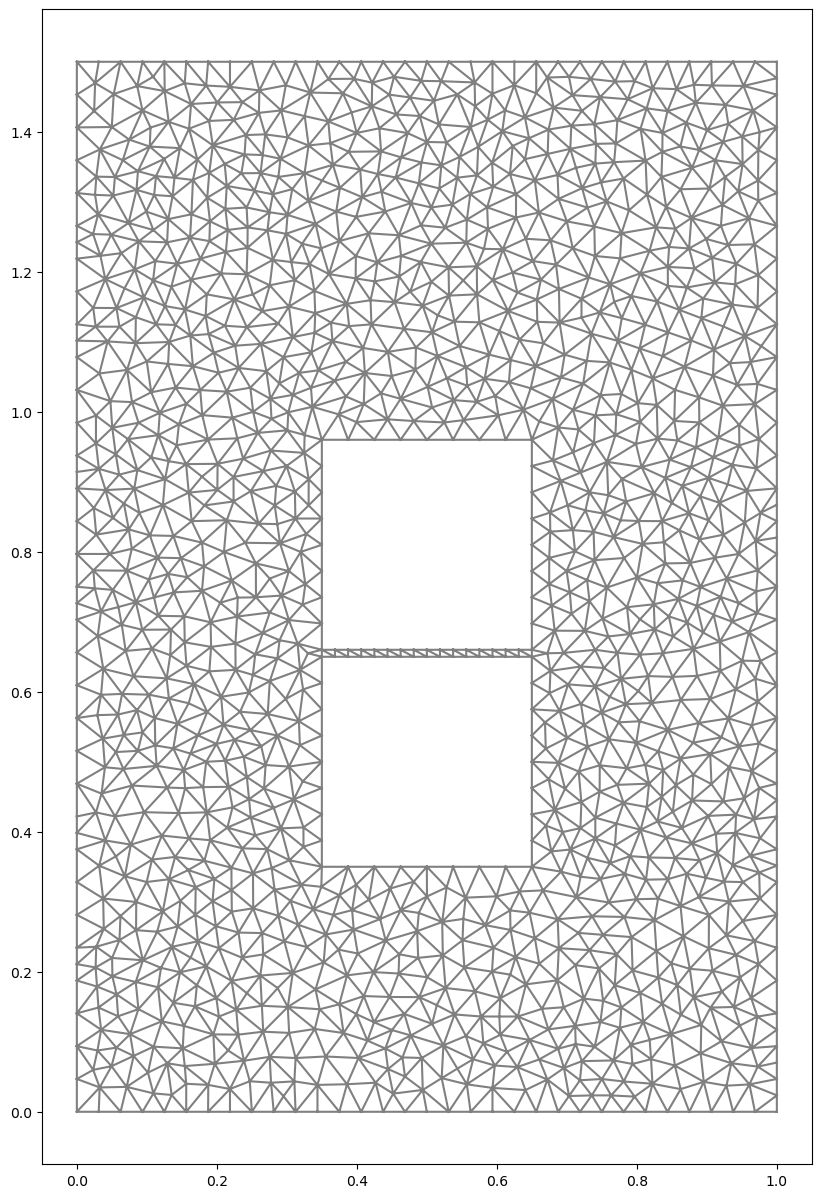

In [2]:
# Create mesh and define function space

#different domains

# external domain

side_x = 1.
side_y = 1.5

square =  Rectangle(Point(0, 0), Point(side_x,side_y))

cyl_square = False
square_2 = True
square_pol = False

if cyl_square:

    gap = 0.01



    ls_i_x = 0.35
    ls_i_y = 0.25
    ls_f_x = 0.65
    ls_f_y = 0.55

    cy_radious = 0.15
    cy_center_x = 0.5
    cy_center_y = ls_f_y + cy_radious + gap


    cylinder =  Circle(Point(cy_center_x, cy_center_y), cy_radious)
    little_square = Rectangle(Point(ls_i_x, ls_i_y), Point(ls_f_x,ls_f_y))
    
    domain = square - little_square - cylinder

if square_2:

    gap = 0.01
    bs_i_x = 0.35
    bs_i_y = 0.35
    bs_f_x = 0.65
    bs_f_y = 0.65

    ts_i_x = 0.35
    ts_i_y = 0.65 + gap
    ts_f_x = 0.65
    ts_f_y = 0.95 + gap
    
    botom_square = Rectangle(Point(bs_i_x, bs_i_y), Point(bs_f_x,bs_f_y))
    top_square = Rectangle(Point(ts_i_x, ts_i_y), Point(ts_f_x,ts_f_y))
    
    domain = square - botom_square - top_square
    
if square_pol:
    
    gap = 0.01

    ls_i_x = 0.35
    ls_i_y = 0.25
    ls_f_x = 0.65
    ls_f_y = 0.55

    p1x = 0.35
    p1y = 0.35
    p2x = 0.65
    p2y = 0.35
    p3x = 0.5
    p3y = 0.65

    triangle_vertices = [
            Point(cy_center_x,cy_center_y + cy_radious),
            Point(cy_center_x - cy_radious, cy_center_y), Point(cy_center_x + cy_radious, cy_center_y)]
    poligono = Polygon(triangle_vertices)

    domain = square - little_square - poligono

mesh =  generate_mesh(domain, 32)

# Plot mesh
mpl.figure(figsize=(10,15))
plot(mesh)

We generate the function space, this are polynomials of degree 1. The first is for the potential, a scalar, the second for the electric field.

In [3]:
V = FunctionSpace(mesh, 'P', 1)
#V = FunctionSpace(mesh, 'CG', 2)
#W = VectorFunctionSpace(mesh, 'P', 1)

Here we give several options: first is to test the code with a "known solution", $u_D=1+x^2+2y^2$, with source $f=-6$. The boundary data (Dirichlet) is given so that it is satisfied. In this option you would get information about how good the solution is, since it prints the $L^2$ and maximun norm of the difference between the exact and numerical solution.
You can change the *exact solution* and acordingly its *source* as you like.

The other options put to zero the potencials of one of the bodies and to 1 that of the other, so running it twice, each with one of the *capacity_* options True generate the whole capacity matrix. One should check that it is **symmetric**.

In [4]:
test1 = False
capacity_01 = False
capacity_10 = True

if test1:
    u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

Next we define the boundaries, they are needed to impose the boundary conditions and then to compute the charges. 

In [5]:
# Define boundary condition


tol = 1.E-14

# boundary_markers = FacetFunction('size_t', mesh)  # Esto fue actualizado
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

class outer_0(SubDomain):
    def inside(self, x, on_boundary):
        return  near(x[0], 0, tol) or near(x[0],1, tol) \
            or near(x[1],0, tol) or near(x[1],1.5, tol)
outer0 = outer_0()
outer0.mark(boundary_markers, 0)
                                 
    
    
if cyl_square:
    
    
    class top_body_1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] > (cy_center_x - cy_radious - tol) and x[0] < (cy_center_x + cy_radious + tol) and x[1] > (cy_center_y - cy_radious - tol) and x[1] < (cy_center_y + cy_radious + tol)
    top = top_body_1()
    top.mark(boundary_markers,1)

    class boton_body_2(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] > (ls_i_x - tol) and x[0] < (ls_f_x + tol) and x[1] > (ls_i_y - tol) and x[1] < (ls_f_y + tol)
    botom = boton_body_2()
    botom.mark(boundary_markers,2)
    
    

if square_2:

    class top_body_1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] > (ts_i_x - tol) and x[0] < (ts_f_x + tol) and x[1] > (ts_i_y - tol) and x[1] < (ts_f_y + tol)
    top = top_body_1()
    top.mark(boundary_markers,1)

    class boton_body_2(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] > (bs_i_x - tol) and x[0] < (bs_f_x + tol) and x[1] > (bs_i_y - tol) and x[1] < (bs_f_y + tol)
    botom = boton_body_2()
    botom.mark(boundary_markers,2)
    

if square_pol:
    
    class top_body_1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] > (ls_i_x - tol) and x[0] < (ls_f_x + tol) and x[1] > (ls_i_y - tol) and x[1] < (ls_f_y + tol)
    top = top_body_1()
    top.mark(boundary_markers,1)

    class boton_body_2(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] > (p1x - tol) and x[0] < (p2x + tol) and x[1] > (p1y - tol) and x[1] < (p3y + tol)
    botom = boton_body_2()
    botom.mark(boundary_markers,2)


# the boundary surface elements 
#ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
             
if capacity_10:
    u_outer = Expression('0', degree=2)
    u_botom = Expression('1', degree=2)
    u_top = Expression('0', degree=2)

if capacity_01:                                 
    u_outer = Expression('0', degree=2)
    u_botom = Expression('-1', degree=2)
    u_top = Expression('1', degree=2)

if capacity_01 or capacity_10:    
    bc_out = DirichletBC(V, u_outer, outer0)
    bc_botom = DirichletBC(V, u_botom, botom)
    bc_top = DirichletBC(V, u_top, top)

if test1:
    bc_out = DirichletBC(V, u_D, outer0)
    bc_botom = DirichletBC(V, u_D, botom)
    bc_top = DirichletBC(V, u_D, top) 

bcs = [bc_out, bc_top, bc_botom]

Next we define the problem (in the weak sense) we want to solve. First the function spaces, then the sources according to the problem and then the matrices and sources to solve a problem of the type $A x = b$. Recall the weak problem is: 
\begin{equation}
\int_{\Omega} \nabla u \cdot \nabla v \; dV = \int_{\Omega} f v \; dV \;\;\;\; \forall \;v \in \; V
\end{equation}

In [6]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

if capacity_01 or capacity_10: 
    f = Constant(-0.0)

if test1:
    f = Constant(-6.0)
#f = Expression('exp(x[0]*x[0] + x[1]*x[1])', degree=2)
    
a = dot(grad(u), grad(v))*dx
L = f*v*dx

We call then a solver with the correct boundary conditions. It doesn't seems to be working. If tolerance is big, it does not refine, if smaller the kernel dies.

In [7]:
# Compute solution
u = Function(V)
M = u*dx()
tol = 1.E-5
#solve(a == L, u, bcs)
problem = LinearVariationalProblem(a, L, u, bcs)
solver = AdaptiveLinearVariationalSolver(problem, M)
solver.parameters["error_control"]["dual_variational_solver"]["linear_solver"] = "cg"
solver.parameters["error_control"]["dual_variational_solver"]["symmetric"] = True
solver.parameters["max_iterations"] = 5
solver.solve(tol)

solver.summary()

Generating forms required for error control, this may take some time...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving variational problem adaptively
Adaptive iteration 0
  Solving linear variational problem.
  Value of goal functional is 0.197652.
  Solving linear variational problem.
  Interpolate from parent to child
Adaptive iteration 1
  Solving linear variational problem

We then plot the solution on screen and save to files the solution in a special format to visualize with Paraview or VisIt.

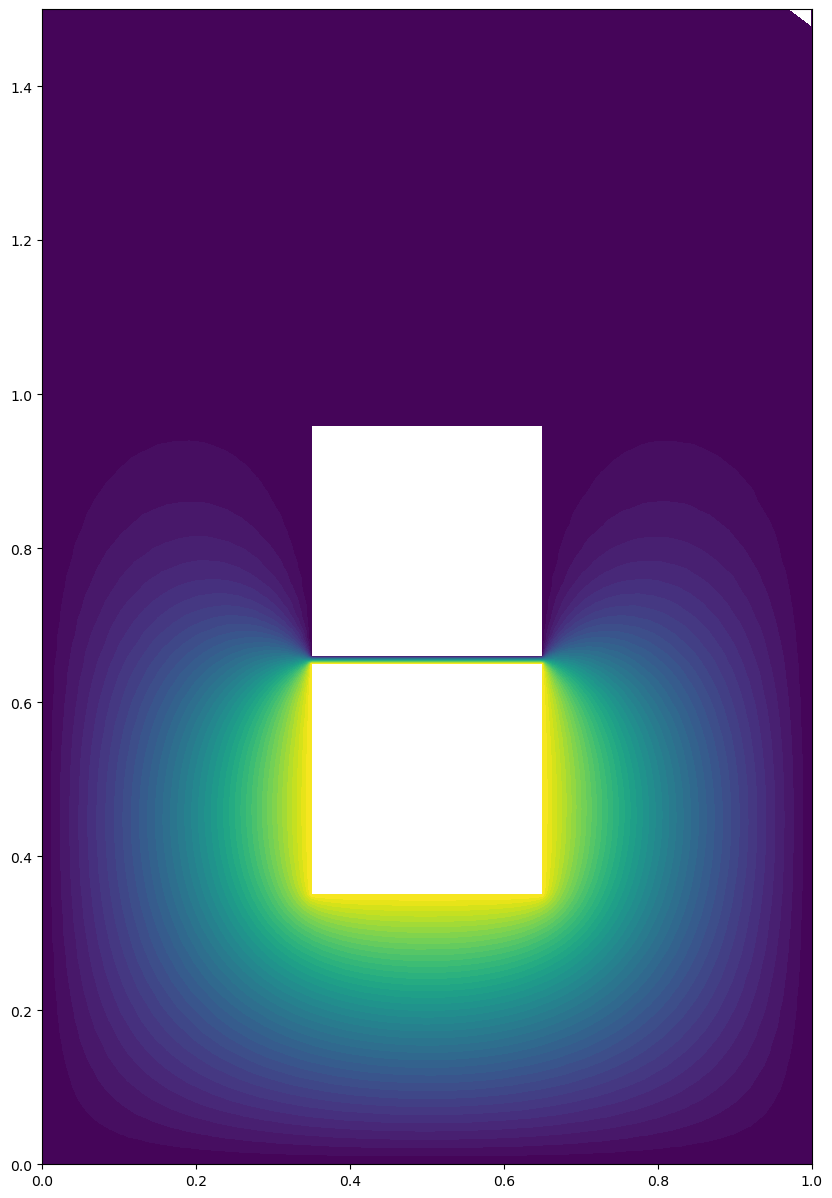

In [9]:
# Plot solution and mesh
mpl.figure(figsize=(10,15))
plot(u.leaf_node())
#plot(mesh.leaf_node())
#plot(u)
#plot(mesh)



# Save solution to file in VTK format

if capacity_01 :
    vtkfile_phi_init = File('Capacity/potential_01_init_mesh.pvd')
    vtkfile_e_init = File('Capacity/field_01_init_mesh.pvd')
    vtkfile_phi = File('Capacity/potential_01_final_mesh.pvd')
    vtkfile_e = File('Capacity/field_01_final_mesh.pvd')

if capacity_10 :
    vtkfile_phi_init = File('Capacity/potential_10_init_mesh.pvd')
    vtkfile_e_init = File('Capacity/field_10_init_mesh.pvd')
    vtkfile_phi = File('Capacity/potential_10_final_mesh.pvd')
    vtkfile_e = File('Capacity/field_10_final_mesh.pvd')

if test1 :
    vtkfile_phi_init = File('Capacity/potential_test_init_mesh.pvd')
    vtkfile_e_init = File('Capacity/field_test_init_mesh.pvd')
    vtkfile_phi = File('Capacity/potential_test_final_mesh.pvd')
    vtkfile_e = File('Capacity/field_test_final_mesh.pvd')

    
#vtkfile_phi << u


vtkfile_phi_init << u.root_node()
vtkfile_phi << u.leaf_node()

We can also compute the electric field and save it in a file.

In [10]:

# Compute de electric field
#W = VectorFunctionSpace(mesh.leaf_node(), 'P', 1)
#W = VectorFunctionSpace(mesh.leaf_node(), 'CG', 2)
W = VectorFunctionSpace(mesh, 'CG', 2) # Lo cambie a lo anterior
#e = project(-grad(u.leaf_node()),W)
e = project(-grad(u),W)   # Lo cambie a lo anterior


vtkfile_e << e

Calling FFC just-in-time (JIT) compiler, this may take some time.


Recall that the charge is defined as: 
\begin{equation}
Q_i = \int_{\partial \Omega_i} \sigma dS =  4\pi\int_{\partial \Omega_i} E \cdot \; dS
\end{equation}
And the **capacity matrix** by the relation: 

\begin{equation}
Q_i = C_{ij}V^j
\end{equation}

In [11]:
# Compute the charge integral
# the boundary surface elements 
#ds = Measure('ds', domain=mesh.leaf_node(), subdomain_data=boundary_markers)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
#n = FacetNormal(mesh.leaf_node())
n = FacetNormal(mesh)
#square_flux = -dot(grad(u),n)*ds(1)
square_flux = dot(e,n)*ds(1)
Q_square = assemble(square_flux)

cyl_flux = dot(e,n)*ds(2)
Q_cyl = assemble(cyl_flux)

print('Charge_square = {0:.4f}, Charge_cyl = {1:.4f} ' .format(Q_square, Q_cyl))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Charge_square = 30.2099, Charge_cyl = -33.6238 


This is to check the code and the boundary conditions, **ALWAYS** run it first! Put above test1=*True*, and both capacities to *False*


In [12]:
if test1:
# Compute error in L2 norm
    error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
    vertex_values_u_D = u_D.compute_vertex_values(mesh)
    vertex_values_u = u.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
    print('error_L2  =', error_L2)
    print('error_max =', error_max)

# Hold plot
#interactive()

Cylinder

10 M=64 I=5 Charge_square = -5.2713, Charge_cyl = 0.5834

10 M=64     Charge_square = -5.1858, Charge_cyl = 0.5843 

Triangle

01 M=32 I=5  Charge_square = 1.5845, Charge_cyl = -2.7196

01 M=64 I=5  Charge_square = 1.6044, Charge_cyl = -2.9414 

01 M=128 I=5 Charge_square = 1.6222, Charge_cyl = -3.0059

01 M=64      Charge_square = 1.5872, Charge_cyl = -3.1374

01 M=128     Charge_square = 1.6036, Charge_cyl = -3.2258 

01 M=256     Charge_square = 1.6374, Charge_cyl = -3.3645 

Two squares

01 M=32 I=5 gap=0.01 Charge_square = 31.8763, Charge_cyl = -34.2799
01 M=32 I=0 gap=0.01 Charge_square = 31.7772, Charge_cyl = -34.6502 
01 M=64 I=0 gap=0.01 Charge_square = 31.8761, Charge_cyl = -34.2575
01 M=128 I=0 gap=0.01 Charge_square = 31.9901, Charge_cyl = -34.3587